<h1>Linear model with independent categorical variable </h1>

In [1]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import statsmodels.api as sm 
import numpy as np 
from statsmodels.iolib.summary2 import summary_col
from skimage import io
import plotly.graph_objs as go
from scipy.stats import pearsonr
from sklearn.preprocessing import LabelEncoder

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def setup_matplot(titlesize=int(14),labelsize=int(12)):
    import matplotlib.pyplot as plt
    plt.rcParams['figure.figsize'] = [8,6]
    plt.rcParams['figure.titlesize'] = titlesize
    plt.rcParams['figure.labelsize'] = labelsize
    return(plt)

In [4]:
plt = setup_matplot()

In [5]:
df_corrupcao = pd.read_csv('../database/corrupcao.csv')

df_corrupcao.head(3)

,pais,cpi,regiao
0,Argentina,3.9,America_do_sul
1,Australia,8.7,Oceania
2,Austria,7.9,Europa


In [6]:
df_corrupcao.groupby('regiao').describe()

cpi                                                  
               count      mean       std  min    25%   50%    75%  max
regiao                                                                
America_do_sul   5.0  4.180000  1.237740  2.8  3.900  4.00  4.000  6.2
Asia            17.0  2.329412  0.898446  0.8  1.800  2.30  2.800  3.8
EUA_e_Canada     2.0  8.000000  1.272792  7.1  7.550  8.00  8.450  8.9
Europa          24.0  6.258333  2.272504  2.1  4.275  6.55  8.125  9.3
Oceania          2.0  9.000000  0.424264  8.7  8.850  9.00  9.150  9.3

In [7]:
contagem = df_corrupcao['regiao'].value_counts(dropna=False)
percent = df_corrupcao['regiao'].value_counts(dropna=False, normalize=True)
pd.concat([contagem, percent], axis=1, keys=['contagem', '%'], sort=False)

,contagem,%
regiao,,
Europa,24,0.48
Asia,17,0.34
America_do_sul,5,0.10
Oceania,2,0.04
EUA_e_Canada,2,0.04


<h2>Exemplo de ponderação arbitrária</h2>

In [8]:
label_encoder = LabelEncoder()
df_corrupcao['regiao_numerico'] = label_encoder.fit_transform(df_corrupcao['regiao'])
df_corrupcao['regiao_numerico'] = df_corrupcao['regiao_numerico'] + 1

df_corrupcao.head(10)

,pais,cpi,regiao,regiao_numerico
0,Argentina,3.9,America_do_sul,1
1,Australia,8.7,Oceania,5
2,Austria,7.9,Europa,4
3,Belgium,7.1,Europa,4
4,Brazil,4.0,America_do_sul,1
5,Canada,8.9,EUA_e_Canada,3
6,Chile,6.2,America_do_sul,1
7,China,2.5,Asia,2
8,Colombia,4.0,America_do_sul,1
9,Cyprus,6.3,Europa,4


In [9]:
df_corrupcao['regiao_numerico'].info()
df_corrupcao.describe()

<class 'pandas.core.series.Series'>
RangeIndex: 50 entries, 0 to 49
Series name: regiao_numerico
Non-Null Count  Dtype
--------------  -----
50 non-null     int64
dtypes: int64(1)
memory usage: 528.0 bytes


,cpi,regiao_numerico
count,50.000000,50.000000
mean,4.894000,3.020000
std,2.678974,1.186489
min,0.800000,1.000000
25%,2.575000,2.000000
50%,3.950000,4.000000
75%,7.475000,4.000000
max,9.300000,5.000000


In [10]:
modelo_corrupcao_errado = sm.OLS.from_formula("cpi ~ regiao_numerico",
                                              df_corrupcao).fit()

#Parâmetros do modelo
print(modelo_corrupcao_errado.summary())

                            OLS Regression Results                            
Dep. Variable:                    cpi   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     33.56
Date:                Sat, 28 Oct 2023   Prob (F-statistic):           5.19e-07
Time:                        21:11:25   Log-Likelihood:                -106.46
No. Observations:                  50   AIC:                             216.9
Df Residuals:                      48   BIC:                             220.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.5200      0.810     

In [11]:
#Calculando os intervalos de confiança com nível de significância de 5%
modelo_corrupcao_errado.conf_int(alpha=0.05)

,0,1
Intercept,-1.108888,2.148957
regiao_numerico,0.945636,1.951029


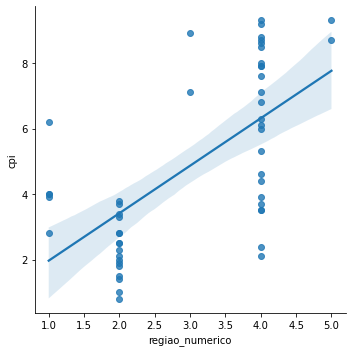

In [12]:
ax =sns.lmplot(
    data=df_corrupcao,
    x="regiao_numerico", y="cpi",
    height=5
)
plt.show()

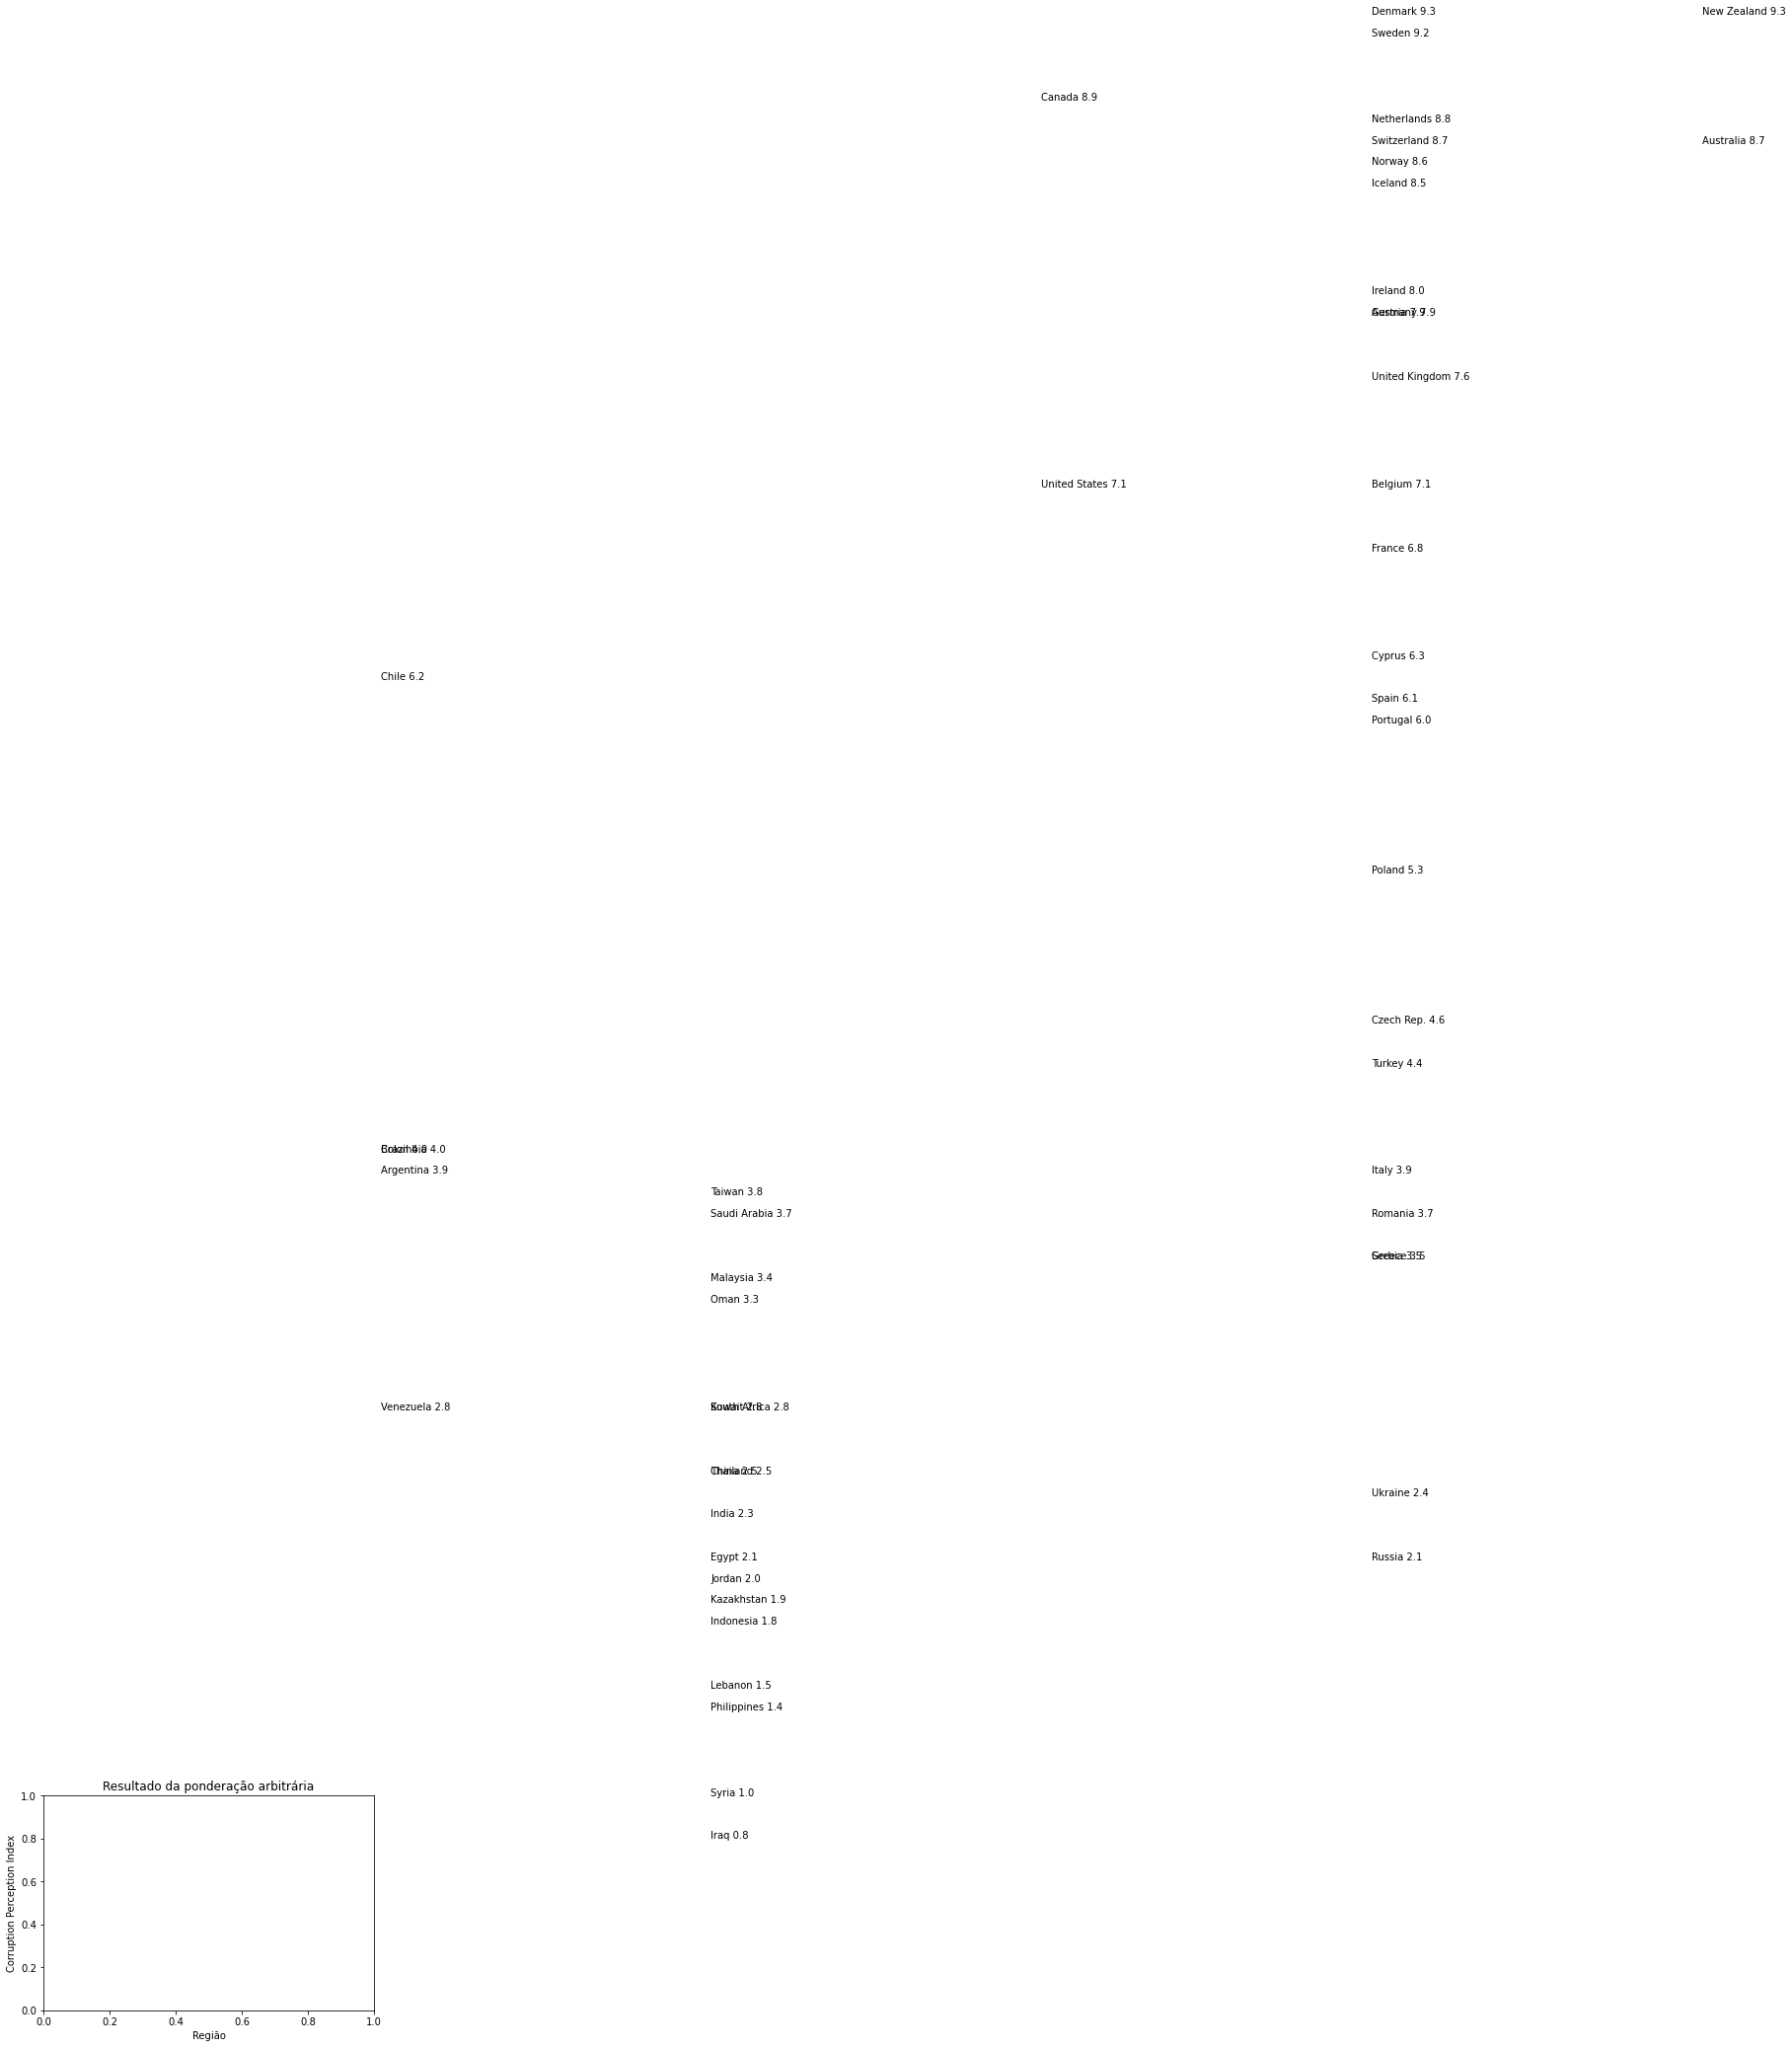

In [13]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']) + " " +
                str(point['y']))

plt.title('Resultado da ponderação arbitrária')
plt.xlabel('Região')
plt.ylabel('Corruption Perception Index')
label_point(x = df_corrupcao['regiao_numerico'],
            y = df_corrupcao['cpi'],
            val = df_corrupcao['pais'],
            ax = plt.gca()) 

<h2>Aplicando o processo de dummização</h2>

In [14]:
df_corrupcao_dummies = pd.get_dummies(df_corrupcao, columns=['regiao'],
                                      drop_first=True)

df_corrupcao_dummies.head(10)

,pais,cpi,regiao_numerico,regiao_Asia,regiao_EUA_e_Canada,regiao_Europa,regiao_Oceania
0,Argentina,3.9,1,False,False,False,False
1,Australia,8.7,5,False,False,False,True
2,Austria,7.9,4,False,False,True,False
3,Belgium,7.1,4,False,False,True,False
4,Brazil,4.0,1,False,False,False,False
5,Canada,8.9,3,False,True,False,False
6,Chile,6.2,1,False,False,False,False
7,China,2.5,2,True,False,False,False
8,Colombia,4.0,1,False,False,False,False
9,Cyprus,6.3,4,False,False,True,False


In [15]:
df_corrupcao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pais             50 non-null     object 
 1   cpi              50 non-null     float64
 2   regiao           50 non-null     object 
 3   regiao_numerico  50 non-null     int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 1.7+ KB


In [16]:
df_corrupcao['regiao'] = df_corrupcao['regiao'].astype("category")
df_corrupcao.info()
df_corrupcao['regiao'] = df_corrupcao['regiao'].astype("string")
df_corrupcao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   pais             50 non-null     object  
 1   cpi              50 non-null     float64 
 2   regiao           50 non-null     category
 3   regiao_numerico  50 non-null     int64   
dtypes: category(1), float64(1), int64(1), object(1)
memory usage: 1.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pais             50 non-null     object 
 1   cpi              50 non-null     float64
 2   regiao           50 non-null     string 
 3   regiao_numerico  50 non-null     int64  
dtypes: float64(1), int64(1), object(1), string(1)
memory usage: 1.7+ KB


In [17]:
modelo_corrupcao_dummies = sm.OLS.from_formula("cpi ~ regiao_Asia + regiao_EUA_e_Canada + regiao_Europa + regiao_Oceania",
                                               df_corrupcao_dummies).fit()
print(modelo_corrupcao_dummies.summary())

                            OLS Regression Results                            
Dep. Variable:                    cpi   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     17.09
Date:                Sat, 28 Oct 2023   Prob (F-statistic):           1.37e-08
Time:                        21:11:27   Log-Likelihood:                -96.620
No. Observations:                  50   AIC:                             203.2
Df Residuals:                      45   BIC:                             212.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [ ]:
import numpy as np 
import scipy.stats as stats
import matplotlib.pyplot as plt

unique_majors = sample_df['major'].unique()
for major in unique_majors:
    stats.probplot(sample_df[sample_df['major'] == major]['salary'], dist="norm", plot=plt)
    plt.title("Probability Plot - " +  major)
    plt.show()

In [18]:
lista_colunas = list(df_corrupcao_dummies.drop(columns=['cpi','pais','regiao_numerico']).columns)

formula_dummies_modelo = ' + '.join(lista_colunas)

formula_dummies_modelo = "cpi ~ " + formula_dummies_modelo

print("Fórmula utilizada: ",formula_dummies_modelo)

Fórmula utilizada:  cpi ~ regiao_Asia + regiao_EUA_e_Canada + regiao_Europa + regiao_Oceania


In [19]:
modelo_corrupcao_dummies = sm.OLS.from_formula(formula_dummies_modelo,
                                               df_corrupcao_dummies).fit()

#Parâmetros do modelo
print(modelo_corrupcao_dummies.summary())

                            OLS Regression Results                            
Dep. Variable:                    cpi   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     17.09
Date:                Sat, 28 Oct 2023   Prob (F-statistic):           1.37e-08
Time:                        21:11:27   Log-Likelihood:                -96.620
No. Observations:                  50   AIC:                             203.2
Df Residuals:                      45   BIC:                             212.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [20]:
# In[ ]: Plotando o modelo_corrupcao_dummies de forma interpolada

#Fitted values do 'modelo_corrupcao_dummies' no dataset 'df_corrupcao_dummies'
df_corrupcao_dummies['fitted'] = modelo_corrupcao_dummies.fittedvalues
df_corrupcao_dummies.head()

,pais,cpi,regiao_numerico,regiao_Asia,regiao_EUA_e_Canada,regiao_Europa,regiao_Oceania,fitted
0,Argentina,3.9,1,False,False,False,False,4.180000
1,Australia,8.7,5,False,False,False,True,9.000000
2,Austria,7.9,4,False,False,True,False,6.258333
3,Belgium,7.1,4,False,False,True,False,6.258333
4,Brazil,4.0,1,False,False,False,False,4.180000


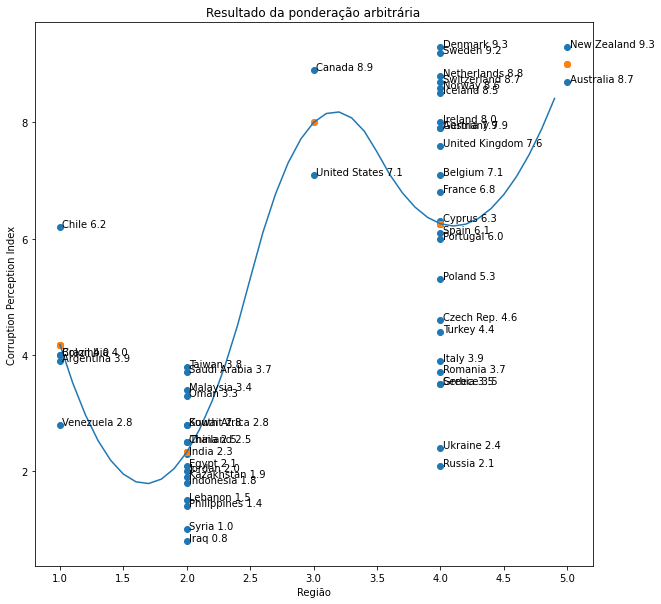

In [21]:
#Gráfico
from scipy import interpolate

plt.figure(figsize=(10,10))

df2 = df_corrupcao_dummies[['regiao_numerico','fitted']].groupby(['regiao_numerico']).median().reset_index()
x = df2['regiao_numerico']
y = df2['fitted']

tck = interpolate.splrep(x, y, k=2)
xnew = np.arange(1,5,0.1) 
ynew = interpolate.splev(xnew, tck, der=0)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']) + " " + str(point['y']))

plt.scatter(df_corrupcao_dummies['regiao_numerico'], df_corrupcao_dummies['cpi'])
plt.scatter(df_corrupcao_dummies['regiao_numerico'], df_corrupcao_dummies['fitted'])
plt.plot(xnew, ynew)
plt.title('Resultado da ponderação arbitrária')
plt.xlabel('Região')
plt.ylabel('Corruption Perception Index')
label_point(x = df_corrupcao['regiao_numerico'],
            y = df_corrupcao['cpi'],
            val = df_corrupcao['pais'],
            ax = plt.gca())